In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
transactions_im = pd.read_csv('transactions_cluster0.csv', header=0)

In [3]:
transactions = transactions_im.fillna(0)

In [4]:
transactions['date'] = pd.to_datetime(transactions['date'], format = '%Y-%m-%d')
transactions = transactions.set_index('date')

In [5]:
ts = transactions.mean(axis=1)

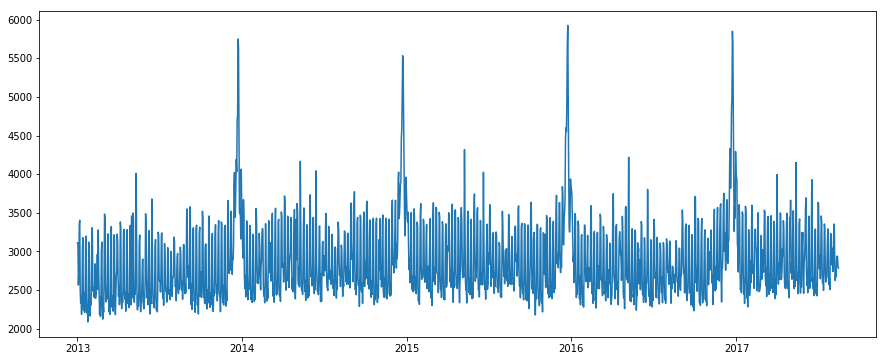

In [6]:
plt.plot(ts.index.to_pydatetime(), ts.values)

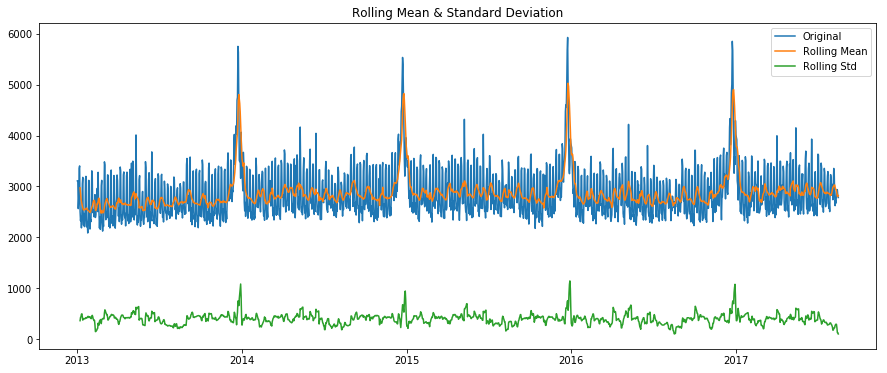

In [7]:
rolmean = ts.rolling(window=7).mean()
rolstd = ts.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [8]:
test = adfuller(ts, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-6.71078696184
P Value: 		3.68529991502e-09
Lags Used: 		23
Observations: 		1664
Critical Value 1%: 	-3.43428594737
Critical Value 5%: 	-2.86327849695
Critical Value 10%: 	-2.56769553371
Information Criterion: 	22799.885627


In [9]:
ts_log = np.log(ts)

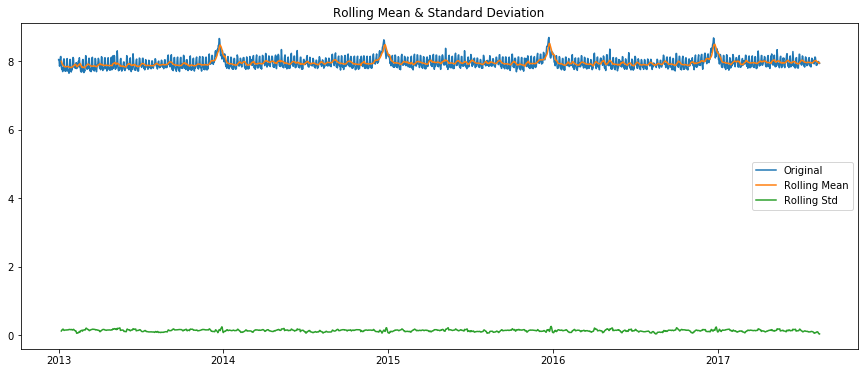

In [10]:
rolmean = ts_log.rolling(window=7).mean()
rolstd = ts_log.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts_log, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
test = adfuller(ts_log, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-6.96159132741
P Value: 		9.13497926572e-10
Lags Used: 		22
Observations: 		1665
Critical Value 1%: 	-3.43428357978
Critical Value 5%: 	-2.86327745188
Critical Value 10%: 	-2.56769497723
Information Criterion: 	-4030.53708756


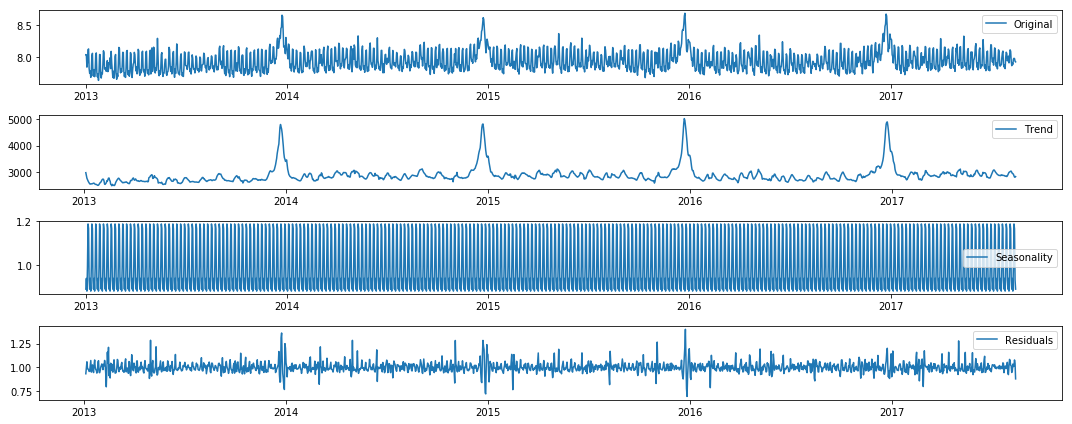

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

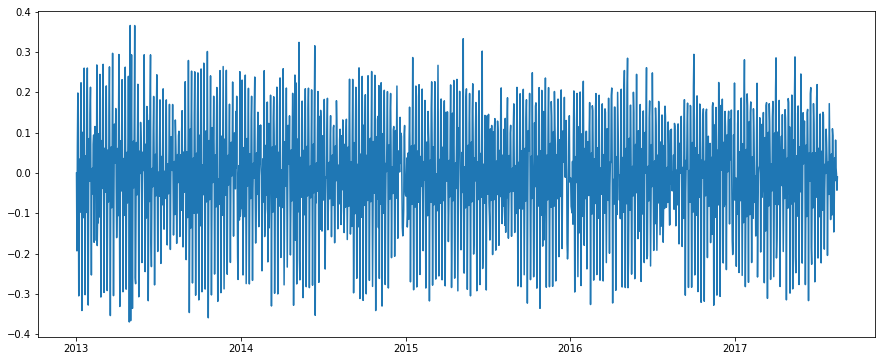

In [13]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)

In [14]:
ts_log_diff.dropna(inplace=True)

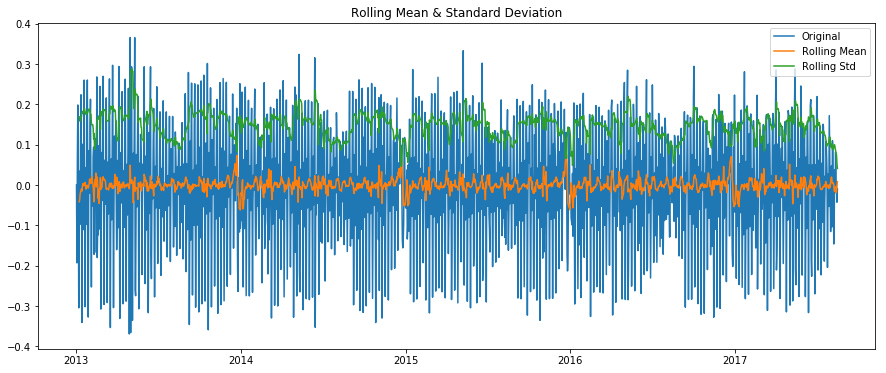

In [15]:
rolmean = ts_log_diff.rolling(window=7).mean()
rolstd = ts_log_diff.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [16]:
test = adfuller(ts_log_diff, autolag='AIC')
print('ADF Statistic: \t\t' + str(test[0]))
print('P Value: \t\t' + str(test[1]))
print('Lags Used: \t\t' + str(test[2]))
print('Observations: \t\t' + str(test[3]))
for key,value in test[4].items():
    print('Critical Value ' + str(key) + ': \t' + str(value))
print('Information Criterion: \t' + str(test[5]))

ADF Statistic: 		-11.6066608841
P Value: 		2.57131858308e-21
Lags Used: 		25
Observations: 		1661
Critical Value 1%: 	-3.43429306728
Critical Value 5%: 	-2.86328163972
Critical Value 10%: 	-2.56769720719
Information Criterion: 	-4014.6648669


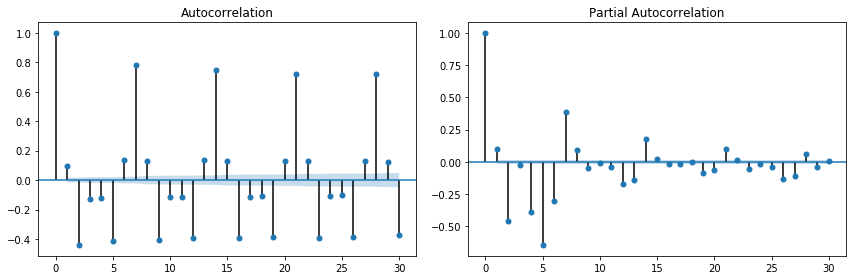

In [17]:
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

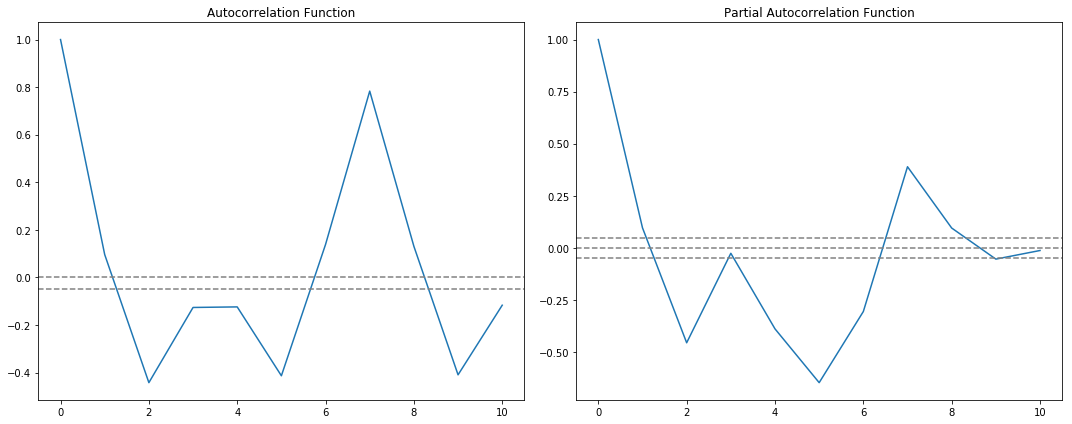

In [18]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [19]:
train_size = int(len(ts_log_diff) * 0.7)
test_size = len(ts_log_diff) - train_size
train, test = ts_log_diff[ts_log_diff.index[0].to_pydatetime():ts_log_diff.index[train_size].to_pydatetime()], ts_log_diff[ts_log_diff.index[train_size].to_pydatetime():ts_log_diff.index[len(ts_log_diff)-1].to_pydatetime()]
print(len(train), len(test))

1181 507


In [20]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff[:1181], trend='n', order=(2,2,1), seasonal_order=(2,2,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1181
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 12)   Log Likelihood                 343.602
Date:                            Thu, 14 Dec 2017   AIC                           -673.203
Time:                                    19:15:43   BIC                           -637.684
Sample:                                01-02-2013   HQIC                          -659.813
                                     - 03-27-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4812      0.019    -25.519      0.000      -0.518      -0.444
ar.L2         -0.7811      0.022   

In [21]:
#predictions=results.predict(start=ts_log_diff.index[0].to_pydatetime(),end=ts_log_diff.index[1686].to_pydatetime(),dynamic=True)

In [22]:
from datetime import datetime, timedelta
format = '%Y-%m-%d'
a=datetime.strptime('2017-02-28',format)
b=datetime.strptime('2017-08-14',format)
predictions=results.predict(start=ts_log_diff.index[1150].to_pydatetime(),end=ts_log_diff.index[1686].to_pydatetime())

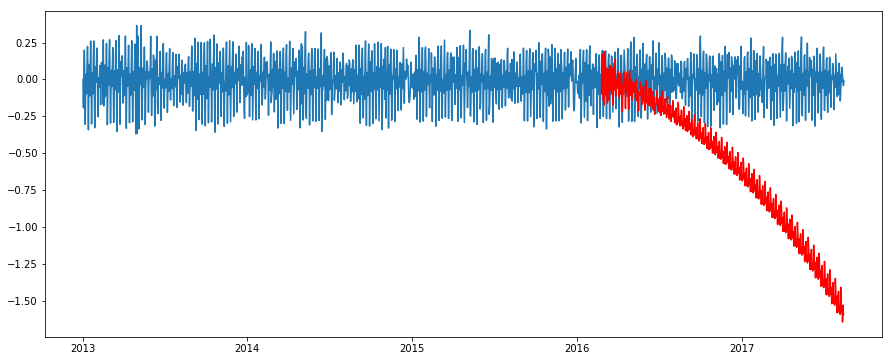

In [23]:
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)
plt.plot(ts_log_diff[1149:1686].index.to_pydatetime(), predictions, color='red')
#plt.title('RSS: %.4f'% sum(predictions-ts_log_diff[1150:1686])**2)

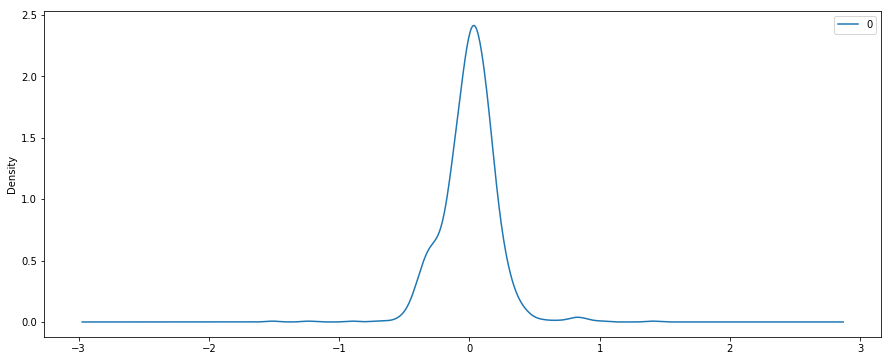

In [24]:
residuals = DataFrame(results.resid)
residuals.plot(kind='kde')

In [25]:
print(residuals.describe())

                 0
count  1181.000000
mean      0.002977
std       0.209060
min      -1.512125
25%      -0.104752
50%       0.015863
75%       0.119725
max       1.409039


In [26]:
predictions_SARIMAX_diff = pd.Series(predictions, copy=True)
print(predictions_SARIMAX_diff.head())

2016-02-26   -0.097426
2016-02-27    0.168491
2016-02-28   -0.006294
2016-02-29    0.072519
2016-03-01   -0.142029
Freq: D, dtype: float64


In [27]:
predictions_SARIMAX_diff_cumsum = predictions_SARIMAX_diff.cumsum()
predictions_SARIMAX_log = pd.Series(ts_log.iloc[0], index=ts_log.index[1150:1686])

In [28]:
predictions_SARIMAX_log = predictions_SARIMAX_log.add(predictions_SARIMAX_diff_cumsum,fill_value=0)

In [29]:
predictions_SARIMAX = np.exp(predictions_SARIMAX_log)

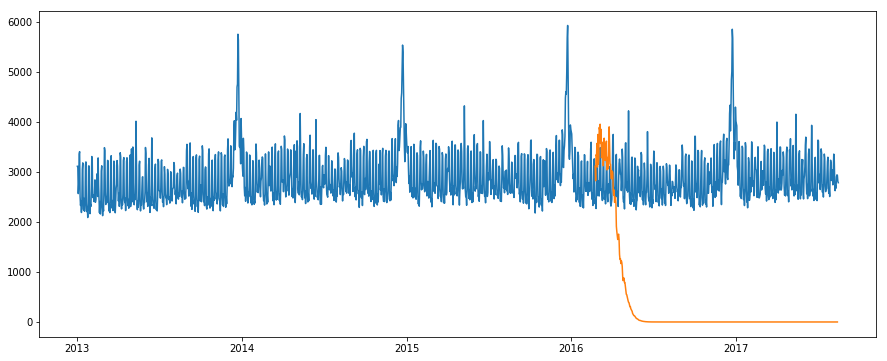

In [30]:
plt.plot(ts.index.to_pydatetime(), ts.values)
plt.plot(ts.index[1148:1686].to_pydatetime(), predictions_SARIMAX.values)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_SARIMAX-ts[1150:1686])**2)/len(ts[1150:1686])))

In [31]:
expected=list(ts)

In [32]:
bias=[expected[i+1148]-predictions_SARIMAX[i] for i in range(len(predictions_SARIMAX))]

In [33]:
mean_forcast_error=sum(bias)/len(bias)
print('Mean forcast error: %f' % mean_forcast_error)

Mean forcast error: 2549.650814


In [34]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected[1148:1686], predictions_SARIMAX)
print('MAE: %f' % mae)

MAE: 2643.152472
